In [1]:
from __future__ import division, unicode_literals, print_function # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import resize

# change the following to %matplotlib notebook for interactive plotting
%matplotlib widget

# Optionally, tweak styles.
mpl.rc('figure', figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [2]:
import os
import numpy as np

# import the packages for reading images and particle tracking
from skimage import io
import trackpy as tp

In [3]:
def crop(img):
    """
    Crop the image to select the region of interest
    """
    x_min = 0
    x_max = -1
    y_min = 0
    y_max = -1
    return img[y_min:y_max,x_min:x_max]

In [35]:
# Set the directory path
glacier_path = 'Z:\Mingxuan Liu'

# The folder where the .tif image stack exists
folder_name = 'tetramer-al-cu-2-1-6fps'

# The file needed to be read
file_name = folder_name + ' binary crop.tif'

# Join the directory path, folder name, and file name to locate .tif images
tif_path = os.path.join(glacier_path, folder_name, file_name)

frames = io.imread(tif_path)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


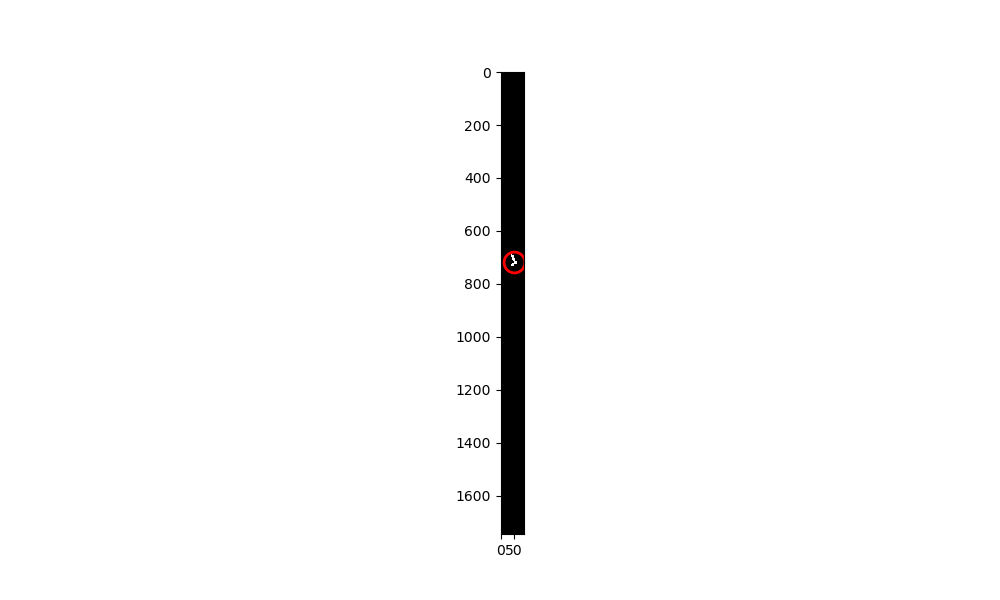

In [36]:
# manually check the binary cropped image
fr = 200
# tracking parameters
params = {
    'diameter': 43,
    'minmass': 3000,
    'invert': False,
    'separation': 15,
}
f = tp.locate(frames[fr], **params);
plt.figure()
image = tp.annotate(f, frames[fr]);

In [37]:
# process particle tracking for all frames
data = tp.batch(frames, **params);

Frame 497: 1 features


In [38]:
# Link the particles in each frame to their positions in previous two frames
link_data = tp.link(data,15,memory=3)

# Group by 'frame' and count the number of particles in each group
group_sizes = link_data.groupby('frame').size()
# Find frames where more than one particle is identified
more_particle_frames = group_sizes[group_sizes > 1]
# Print the frame numbers
print("Frames below have identified more than one particle:")
print(more_particle_frames.index.tolist())

Frame 497: 1 trajectories present.
Frames below have identified more than one particle:
[]


In [39]:
print(link_data)
link_data.to_csv(os.path.join(glacier_path, folder_name, folder_name + ' binary.csv'))

               y          x          mass       size       ecc      signal  \
0      48.745825  33.840804  70845.246378  10.958896  0.386346  213.529339   
1      52.621969  34.122942  70084.886147  10.980499  0.390807  213.058054   
2      55.407362  34.095467  70864.583239  11.116492  0.390320  214.660501   
3      58.360986  34.021613  69606.547630  11.059492  0.393323  214.665411   
4      62.154604  34.263295  69248.984284  11.069640  0.410485  214.657368   
..           ...        ...           ...        ...       ...         ...   
493  1700.839108  64.787885  67119.985833  10.710008  0.353976  214.988673   
494  1703.977748  64.622458  67553.709190  10.834540  0.358667  215.740389   
495  1707.738115  64.879548  66925.458085  10.643877  0.345547  215.084757   
496  1710.414517  64.883529  67354.993693  10.683766  0.350354  215.859072   
497  1700.186844  62.434783  58214.208525  10.981295  0.650705  220.829835   

     raw_mass   ep  frame  particle  
0     99705.0  0.0      0